
### <center>Procesamiento Digital de Señales de Audio</center>
#### <center>Instituto de Ingeniería Eléctrica - UdelaR</center>
# Hoja de Ejercicios 2 - Curso 2024
## Introducción al procesamiento de audio.
### Filtros digitales en audio.

## Pautas para el práctico
 - La realización del presente trabajo es individual.
 - Se espera la entrega de un PDF escrito en $\LaTeX$ o similar. El mismo tendrá:
     - Máximo de 12 páginas
     - Máximo de 2500 palabras
 - También se espera la entrega del código escrito, en scripts Python o en este mismo Jupyter Notebook.
 - La corrección del práctico se hará sobre lo entregado en el PDF, pero podremos apoyarnos en el razonamiento y comprensión demostrado en el código escrito. Recomendamos escribir el código de forma prolija para facilitar la comprensión presente y futura tanto de nosotros como de ustedes. Exhortamos comentar el código para su mejor comprensión.


**Nombre de el/la estudiante:** Silvina Datz

### Como correr este notebook

Es posible descargarlo y correrlo localmente en su computadora

Tambien pueden correrlo en Google Colab usando el siguiente link.

<table align="center">
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/mrocamora/audio-dsp/blob/main/practicos/AudioDSP_Practico_2.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Correr en Google Colab</a>
  </td>
</table>

In [94]:
# Al correr esta celda, se podrá acceder a archivos
# y carpetas en su cuenta de google drive.
# Puede ver la estructura de carpetas apretando en
# el icono de carpeta de la barra lateral izquierda.
# from google.colab import drive
# drive.mount('/content/drive')

In [95]:
# Directorio de archivos
dir_files = './Archivos_P2/'

In [96]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import io, signal
from scipy.io.wavfile import read
from IPython.display import Audio
from scipy.signal import butter, lfilter, find_peaks
from numpy.fft import fft, fftfreq, fftshift
from tabulate import tabulate

# Ejercicio 1

Al analizar una grabación de música con técnicas de procesamiento digital de señales, resulta de utilidad obtener una representación intermedia de la señal de audio que preserve sus principales propiedades rítmicas. Para generar tal representación, en [1] se propone descomponer la señal en bandas de frecuencia con un banco de filtros y calcular la envolvente de amplitud de la salida de cada filtro. Como forma de mostrar la validez de la propuesta, en [1] se plantea un experimento en el que al filtrar ruido blanco con el mismo banco de filtros, modular la salida de los filtros con las envolventes de amplitud previamente calculadas y sumar las señales de todas las bandas, se puede construir una nueva señal de audio que preserva las características rítmicas de la señal original.

## Parte 1


En la Figura 1 se muestra un diagrama de bloques del proceso, el cual se implementará en este ejercicio. Los pasos a seguir son los siguientes:  

---

<img src="https://github.com/mrocamora/audio-dsp/blob/main/practicos/figures/diagrama.svg?raw=1" alt="FIG 1" style="width: 600px;">

`FIG 1: Diagrama de bloques del procesamiento. Los filtros $H_1$ ... $H_n$ conforman el banco de filtros.`

---

Los pasos son los siguientes:

1. Implementar un banco de filtros Butterworth según la siguiente tabla. Se sugiere usar *scipy.signal.butter* y puede resultar útil consultar https://scipy-cookbook.readthedocs.io/items/ButterworthBandpass.html


| Banda | $f_{low}$(Hz) | $f_{high}$(Hz) | tipo |
| :- | :---- | :---- | :--------------------- |
| 1 | - | 100 | pasa-bajo |
| 2 | 100 | 200 | pasa-banda |
| 3 | 200 | 400 | pasa-banda |
| 4 | 400 | 800 | pasa-banda |
| 5 | 800 | 1600 | pasa-banda |
| 6 | 1600 | - | pasa-alto |


2. Filtrar la señal de audio provista ([*ethno-beat_8k.wav*](./Archivos_P2/ethno-beat_8k.wav) [2], extraída de [FreeSound](https://freesound.org/)) con el banco de filtros y graficar forma de onda y espectrograma de las señales resultantes.  
3. Calcular la envolvente temporal de cada una de las señales resultantes. Para ello se recomienda rectificar la señal y aplicar un filtro pasabajos.
4. Generar una señal de ruido blanco con la misma cantidad de muestras que la señal de audio y filtrarla con el banco de filtros de la parte 1.
5. Modular en amplitud las señales de ruido filtrado con las envolventes calculadas en la parte 2. Escuchar el resultado para cada una de las bandas.
6. Sumar las señales moduladas para obtener la salida y comparar auditivamente el contenido rítmico de la señal obtenida y la original.

_**Sugerencia**:_ implementar la función de filtrado de manera que tome como entrada:
* la cantidad de filtros a utilizar.
* la primer frecuencia de corte $f_1$ (en el caso de la tabla anterior corresponde al $f_{high}=100~ Hz$ del pasabajos)
* el factor logarítmico multiplicativo para la demas frecuencias de corte (en este caso, corresponde a 2)

Esto último será de utilidad para las dos partes del ejercicio.

In [97]:
# Cargar audio

sr, data = io.wavfile.read(dir_files+'ethno-beat_8k.wav')

# Pasar de estéreo a mono
if len(data.shape) > 1:
    data = (data[:,0].astype(float) + data[:,1].astype(float))/2

Audio(data, rate=sr)

1.

In [98]:
def filter_bank_butterworth(x, fs, num_filters, order, first_cutoff_freq, factor_cutoff):
    """
    Banco de filtros de Butterworth

    Args:
        x (np.array): Señal de entrada
        fs (int): Frecuencia de muestreo
        num_filters (int): Número de filtros
        order (int): Orden del filtro
        first_cutoff_freq (int): Frecuencia de corte del primer filtro
        factor_cutoff (float): Factor de aumento de la frecuencia de corte

    Returns:
        np.array(num_filters, len(x)): Señal filtrada por cada filtro
    """
    y = np.empty((num_filters, len(x)))
    for i in range(num_filters):
        if i==0:
            b, a = butter(order, first_cutoff_freq, btype='low', fs=fs)
        elif i==num_filters-1:
            b, a = butter(order, first_cutoff_freq * factor_cutoff**(i-1), btype='high', fs=fs)
        else:
            low = first_cutoff_freq * factor_cutoff**(i-1)
            high =  first_cutoff_freq * factor_cutoff**i
            b, a = butter(order, [low, high], btype='band', fs=fs)
        y[i] = lfilter(b, a, x)
    return y

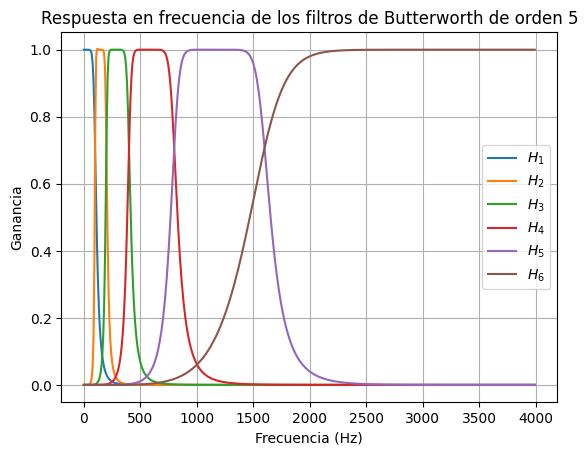

In [99]:
order = 5
num_filters = 6
fs = 8000
first_cutoff_freq=100
factor_cutoff=2

plt.figure()
for i in range(num_filters):
    if i==0:
        b, a = butter(order, first_cutoff_freq, btype='low', fs=fs)
    elif i==num_filters-1:
        b, a = butter(order, first_cutoff_freq * factor_cutoff**(i-1), btype='high', fs=fs)
    else:
        low = first_cutoff_freq * factor_cutoff**(i-1)
        high =  first_cutoff_freq * factor_cutoff**i
        b, a = butter(order, [low, high], btype='band', fs=fs)
    w, h = signal.freqz(b, a, fs=fs)
    plt.plot(w, abs(h), label=f'$H_{i+1}$')
plt.legend()
plt.grid(True)
plt.xlabel("Frecuencia (Hz)")
plt.ylabel("Ganancia")
plt.title(f'Respuesta en frecuencia de los filtros de Butterworth de orden {order}')
plt.show()

2.

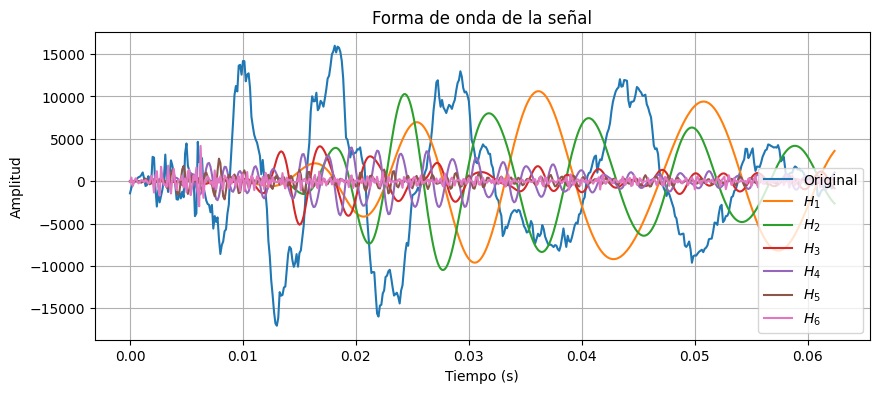

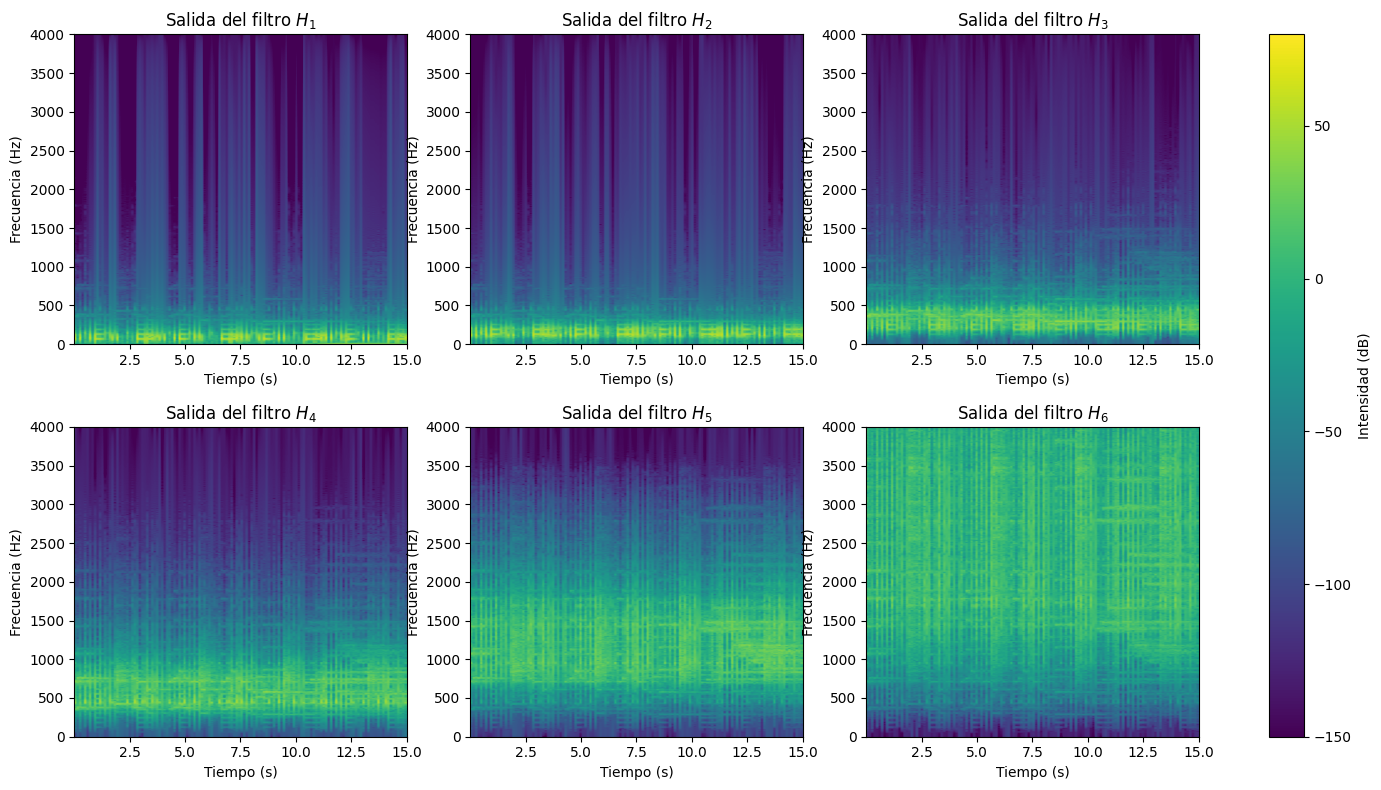

In [100]:
num_filters = 6
y = filter_bank_butterworth(x=data, fs=sr, num_filters=num_filters, order=6, first_cutoff_freq=100, factor_cutoff=2)
t = np.linspace(0, len(data)/sr, len(data))

# graficar forma de onda
plt.figure(figsize=(10, 4))
plt.plot(t[:500], data[:500], label='Original')
for i in range(y.shape[0]):
    plt.plot(t[:500], y[i][:500], label=f'$H_{i+1}$')
plt.title('Forma de onda de la señal')
plt.xlabel('Tiempo (s)')
plt.ylabel('Amplitud')
plt.grid(True)
plt.legend()
plt.show()

# graficar espectograma
fig, axes = plt.subplots(2, 3, figsize=(15, 8))
vmin, vmax = -150, 80
for i in range(num_filters):
    ax = axes[i // 3, i % 3]  # Selecciona el subplot correspondiente
    spec, freqs, t, im = ax.specgram(y[i], Fs=sr, NFFT=1024, vmin=vmin, vmax=vmax)
    ax.set_title(f'Salida del filtro $H_{i+1}$')
    ax.set_xlabel('Tiempo (s)')
    ax.set_ylabel('Frecuencia (Hz)')
plt.tight_layout()
plt.colorbar(im, ax=axes, label='Intensidad (dB)', orientation='vertical')
plt.show()

3.

In [101]:
def max_short_time(x, fs, win_size, window_type='rectangular'):
    """
    Computes maximum values of short-time frames of the audio waveform.
    """
    # signal length in samples
    L = x.shape[0]

    # window size in samples
    win_samp = round(win_size * fs)

    # ensure window size is odd
    if win_samp % 2 == 0:
        win_samp += 1
    half_win = win_samp // 2
    
    # create window
    window = signal.windows.get_window(window_type, win_samp)
    
    # empty array for the output signal
    y = np.zeros(L)

    # compute maximum value for each sample
    for i in range(L):
        if i < half_win:
            # Left border case
            frame = x[:i + half_win + 1]
            win = window[half_win - i:]
        elif i >= L - half_win:
            # Right border case
            frame = x[i - half_win:]
            win = window[:L - i + half_win]
        else:
            # General case
            frame = x[i - half_win:i + half_win + 1]
            win = window
        
        # Apply window and compute max
        y[i] = np.max(np.abs(frame * win))
    
    return y

In [102]:
def filtro_media_movil(signal, window_size):
    # Asegurarse de que window_size es impar
    if window_size % 2 == 0:
        window_size += 1
    half_window = window_size // 2

    signal_length = len(signal)
    filtered_signal = np.zeros(signal_length)

    for i in range(len(signal)):
        if i < half_window:
            # Caso borde izquierdo
            window = signal[: i + half_window + 1]
        elif i >= signal_length - half_window:
            # Caso borde derecho
            window = signal[i - half_window :]
        else:
            # Caso general
            window = signal[(i - half_window) : (i + half_window + 1)]
        
        filtered_signal[i] = np.mean(window)

    return filtered_signal

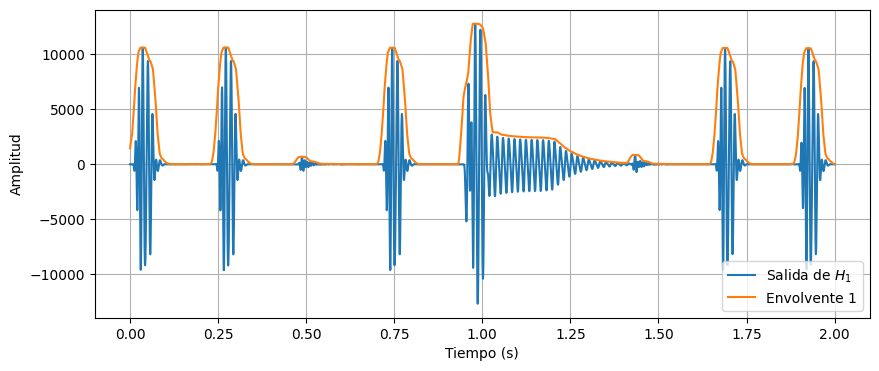

In [103]:
# calcular envolventes

envolventes = np.empty((6, len(data)))
for i in range(y.shape[0]):

    # rectificar
    max_amp= max_short_time(y[i], sr, win_size=0.025)

    # LPF
    envolventes[i] = filtro_media_movil(max_amp, 100)

# graficar forma de onda
t = np.linspace(0, len(data)/sr, len(data))
plt.figure(figsize=(10, 4))
plt.plot(t[:16000], y[0][:16000], label=f'Salida de $H_1$')
plt.plot(t[:16000], envolventes[0][:16000], label=f'Envolvente {1}')
plt.xlabel('Tiempo (s)')
plt.ylabel('Amplitud')
plt.grid(True)
plt.legend()
plt.show()

4.

In [104]:
white_noise = np.random.normal(0, 1, len(data))
white_noise_filtered = filter_bank_butterworth(x=white_noise, fs=sr, num_filters=6, order=5, first_cutoff_freq=100, factor_cutoff=2)

5.

In [105]:
# modular en amplitud el ruido filtrado con las envolventes
modulacion = np.empty(envolventes.shape)
for i in range(envolventes.shape[0]):
    modulacion[i] = white_noise_filtered[i] * envolventes[i]

In [106]:
# escuchar audio modulado
Audio(modulacion[0], rate=sr)

In [107]:
Audio(modulacion[1], rate=sr)

In [108]:
Audio(modulacion[2], rate=sr)

In [109]:
Audio(modulacion[3], rate=sr)

In [110]:
Audio(modulacion[4], rate=sr)

In [111]:
Audio(modulacion[5], rate=sr)

6.

In [112]:
salida = np.sum(modulacion, axis=0)

In [113]:
Audio(salida, rate=sr)

## Parte 2

En esta parte se explorará el mismo procedimiento que la Parte 1 sobre el audio [_tamy_8k.wav_](./Archivos_P2/tamy_8k.wav), que contiene únicamente voz cantada y guitarra (sin instrumentos "percusivos").

Repita el procedimiento anterior, pero **aumentando el número de bandas a 12**. Para ello puede ser útil separar logarítmicamente las frecuencias de corte por un factor de $1.4$ .

Evaluar perceptualmente los resultados del audio sintetizado y responder:

1. ¿Es posible identificar la melodía de la guitarra y la voz?
1. ¿Se puede identificar cuándo ocurren los ataques de las notas en la guitarra?
1. ¿Se pueden percibir características de los fonemas de la voz?

Comente y justifique **brevemente** todas sus respuestas.

In [114]:
sr, data = io.wavfile.read(dir_files+'tamy_8k.wav')
if len(data.shape) > 1:
    data = (data[:,0].astype(float) + data[:,1].astype(float))/2

Audio(data=data, rate=sr)

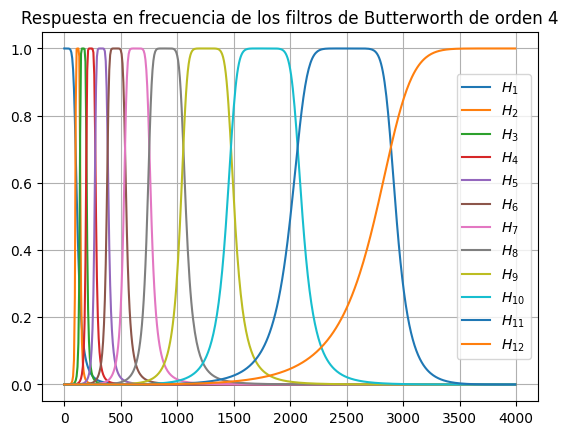

In [115]:
order = 4
num_filters = 12
fs = 8000
first_cutoff_freq=100
factor_cutoff=1.4

plt.figure()
for i in range(num_filters):
    if i==0:
        b, a = butter(order, first_cutoff_freq, btype='low', fs=fs)
    elif i==num_filters-1:
        b, a = butter(order, first_cutoff_freq * factor_cutoff**(i-1), btype='high', fs=fs)
    else:
        low = first_cutoff_freq * factor_cutoff**(i-1)
        high =  first_cutoff_freq * factor_cutoff**i
        b, a = butter(order, [low, high], btype='band', fs=fs)
    w, h = signal.freqz(b, a, fs=fs)
    plt.plot(w, abs(h), label=f"$H_{{{i+1}}}$")
plt.legend()
plt.grid(True)
plt.title(f'Respuesta en frecuencia de los filtros de Butterworth de orden {order}')
plt.show()

In [116]:
num_filters = 12
order=  4
first_cutoff_freq = 100
factor_cutoff = 1.4

data_filtered = filter_bank_butterworth(data, sr, num_filters, order, first_cutoff_freq, factor_cutoff)

envolventes = np.empty((num_filters, len(data)))
for i in range(data_filtered.shape[0]):
    # rectificar
    max_amp = max_short_time(data_filtered[i], sr, win_size=0.025)
    # LPF
    envolventes[i] = filtro_media_movil(max_amp, 100)

white_noise = np.random.normal(0, 1, len(data))
white_noise_filtered = filter_bank_butterworth(white_noise, sr, num_filters, order, first_cutoff_freq, factor_cutoff)

modulacion = np.empty(envolventes.shape)
for i in range(envolventes.shape[0]):
    modulacion[i] = white_noise_filtered[i] * envolventes[i]

salida = np.sum(modulacion, axis=0)

Audio(salida, rate=sr)

Al escuchar el audio no se pueden distinguir las notas de la voz y de la guitarra, sin embargo sí se pueden distinguir los fonemas de la voz y los ataques de la guitarra. En el proceso se utiliza ruido blanco, que no contiene información de tono, por eso se pierden las notas de la guitarra y voz. Por otro lado la envolvente de la canción original captura los patrones temporales de energía en cada banda de frecuencia, por ese motivo se logra identificar los ataques de la guitarra y los fonemas de la voz, así como la rítmica de la canción.

# Ejercicio 2

En este ejercicio se implementa el algoritmo de Karplus y Strong para síntesis de cuerda pulsada [3]. Se sugiere consultar [4] por una descripción detallada.


## Parte 1

Como primer paso se estudia la respuesta al impulso de un filtro peine.


1. Escribir la ecuación en recurrencia de un filtro peine en función del retardo $L$ y la atenuación por muestra $R$ del filtro. Indicar la frecuencia fundamental de la respuesta al impulso en función de los parámetros del filtro y la frecuencia de muestreo ¿Es posible conseguir una respuesta al impulso con frecuencia fundamental arbitraria?
2. Sintetizar las 12 notas de una octava de la *escala igualmente temperada* (en el temperamento igual se divide la octava en 12 intervalos iguales, de modo que las frecuencias de dos notas consecutivas cumplen la relación $f_{n+1} = f_{n} \, 2^{(\frac{1}{12})}$) comenzando en $110~Hz$ ($A2$). Para esto, se sugiere hacer lo siguiente:

     - Calcular el parámetro $L$ del filtro para que la frecuencia fundamental de la respuesta al impulso sea lo más cercana posible a la nota deseada. Utilice una frecuencia de muestreo de $f_s$ = $22050~Hz$).

     - Filtrar un impulso con cada uno de los filtros diseñados.
     - Concatenar la respuesta al impulso de cada filtro para obtener una señal con todas las notas.
    

3. Variar el parámetro $R$ y analizar su efecto mediante un espectrograma.

1.

Ecuación en recurrencia de un filtro peine: $y[n] = x[n] + R^Lx[n − L]$

La frecuencia fundamental de la respuesta al impulso es $f_0=f_s/L$

En teoría, es posible conseguir una frecuencia fundamental arbitraria ajustando el retardo L. Sin embargo, en la práctica, hay limitaciones:
a) L debe ser un número entero de muestras, lo que limita la resolución de las frecuencias que se pueden obtener.
b) La frecuencia más baja está limitada por el tamaño máximo del buffer de retardo que se puede implementar.
c) La frecuencia más alta está limitada por el teorema de Nyquist, que establece que la frecuencia máxima que se puede representar es la mitad de la frecuencia de muestreo.


2.

In [117]:
def filtro_peine(x, L, R):
    """
    Filtro peine

    y[n] = x[n] + R^L * y[n - L]

    Args:
        x(np.array): señal de entrada
        L (int): parámetro L del filtro peine
        R (float): parámetro R del filtro peine

    Returns:
        np.array: señal de salida
    """

    y = np.zeros(len(x))
    y[:L] = x[:L]
    for n in range(L, len(x)):
        y[n] = x[n] + R**L * y[n - L]
    return y

In [118]:
def delta(length):
    x = np.zeros(length)
    x[0] = 1
    return x

In [119]:
fs = 22050
R = 0.999
f0 = 110
duration_s = 0.5 # duracion de cada nota


# generar las 12 notas
notes = []
for i in range(12):
    fn = f0 * 2**(i / 12)
    L = int(round(fs / fn))

    # Señal de entrada
    x = delta(int(fs*duration_s))

    # Filtro peine
    note = filtro_peine(x, L, R)

    notes.append(note)

# concatenar todas las notas
y = np.concatenate(notes)

Audio(y, rate=fs)

3.

/tmp/ipykernel_6848/1685609083.py:18: RuntimeWarning: divide by zero encountered in log10
  plt.pcolormesh(t, f, 10 * np.log10(Sxx), shading='gouraud')


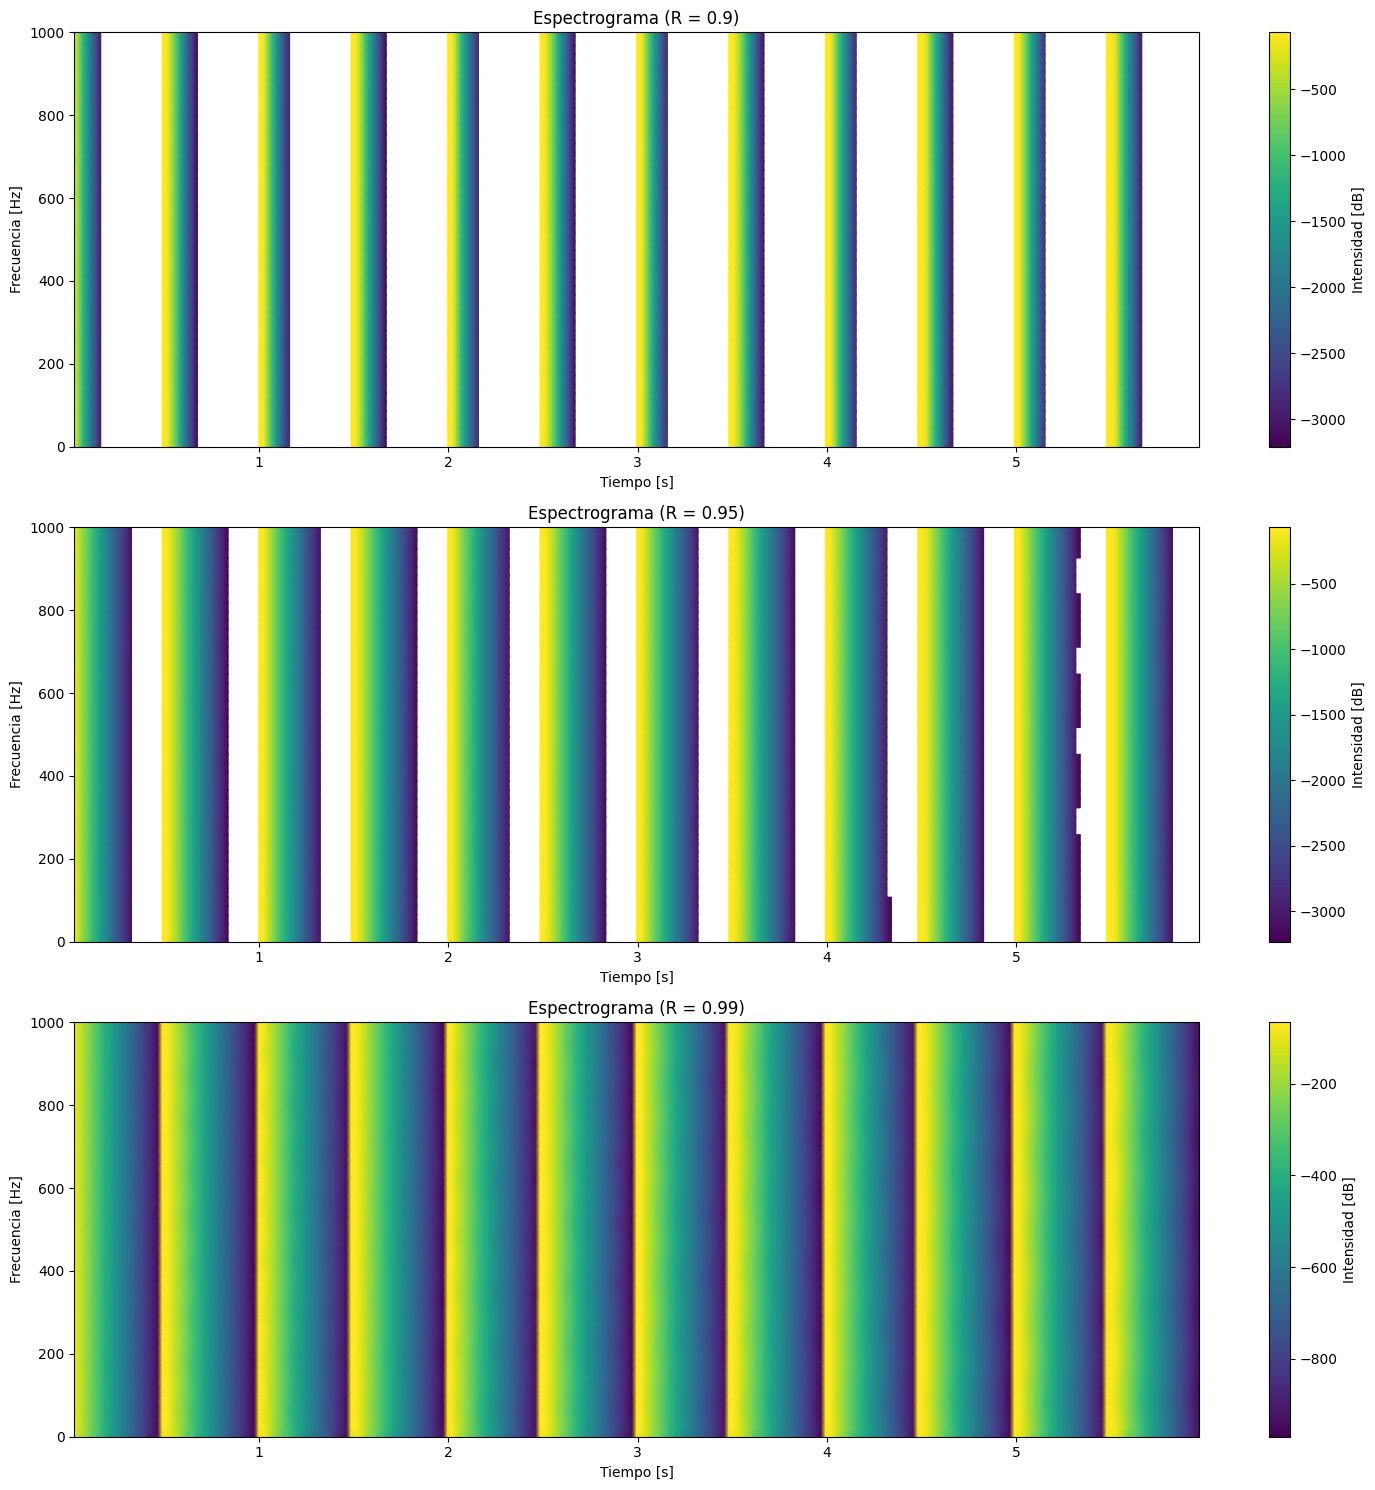

In [120]:
R_values = [0.9, 0.95, 0.99]
fs = 22050

fig, ax = plt.subplots(len(R_values), figsize=(15, 5 * len(R_values)))
for i, R in enumerate(R_values):
    notes = []
    for j in range(12):
        f0 = 110 * (2 ** (j / 12))
        L = int(round(fs / f0))
        x = delta(int(fs*duration_s))
        note = filtro_peine(x, L, R)
        notes.append(note)
    y = np.concatenate(notes)
    
    f, t, Sxx = signal.spectrogram(y, fs, nperseg=1024, noverlap=512)
    
    plt.subplot(len(R_values), 1, i+1)
    plt.pcolormesh(t, f, 10 * np.log10(Sxx), shading='gouraud')
    plt.ylabel('Frecuencia [Hz]')
    plt.xlabel('Tiempo [s]')
    plt.title(f'Espectrograma (R = {R})')
    # plt.title(f'R = {R}')
    plt.colorbar(label='Intensidad [dB]')
    plt.ylim(0, 1000)

plt.tight_layout()
plt.show()

## Parte 2

Como primer refinamiento del modelo se incluye un filtro pasabajos en el lazo de realimentación.
En [3] se usa un filtro de media móvil de primer orden ($M=2$).


1. ¿Qué característica de la señal de una cuerda pulsada modela este filtro?
1. Calcular la ecuación en recurrencia del filtro peine incluyendo el pasabajos en el lazo de realimentación.
1. Indicar la frecuencia fundamental de la respuesta al impulso en función de los parámetros del filtro peine y la frecuencia de muestreo.
1. Repetir el punto 2 de la parte 1 con el sistema incluyendo el pasabajos.
1. Evaluar auditivamente el resultado de la síntesis al agregar el pasabajos.

1. La atenuación de las altas frecuencias en cada retorno

El filtro de media móvil de primer orden en el lazo de realimentación modela la pérdida de energía de las frecuencias altas en una cuerda pulsada. En una cuerda real, las frecuencias más altas tienden a amortiguarse más rápidamente que las frecuencias bajas. Este filtro pasabajos simula este comportamiento, haciendo que el sonido sea más natural y menos "metálico".

2.


Pasa-bajos: $L(z)=\frac{1}{2}(1+z^{-1})$

Planteando $\frac{Y(z)}{X(z)} = \frac{L(z)}{1 - L
(z) R^{L}z^{-L}}$ se obtiene la siguiente ecuación en recurrencia:

$y[n] = \frac{1}{2} (x[n]+x[n-1]+R^L y[n-L] +R^L y[n-L-1])$


3.

La función de transferencia del filtro de media móvil es $L(e^{j\theta})=\frac{1}{2} (1+e^{-j\theta})=e^{-\frac{j\theta}{2}}cos(\frac{\theta}{2})$, por lo tanto su fase es $\arg(L(e^{j\theta}))=-\frac{\theta}{2}$. A partir de la expresión podemos ver que es de fase lineal, y que el retardo de grupo es constante (1/2 muestra) para todas las frecuencias.

Por lo tanto, la frecuencia fundamental del filtro peine se verá afectada por este retardo constante de 1/2 muestra, resultando en $f_0 = \frac{f_s}{L+\frac{1}{2}}$

4.

In [121]:
def filtro_peine_con_pasabajos(x, L, R):
    """
    Filtro peine con filtro pasabajos
    
    y[n] = (1/2) * (x[n] + R^L * y[n - L] + x[n-1] + R^L * y[n - L - 1])

    Args:
        x(np.array): señal de entrada
        L (int): parámetro L del filtro peine
        R (float): parámetro R del filtro peine

    Returns:
        np.array: señal de salida
    """
    
    # Padding para manejar x[n-1] cuando n=0.
    # x_padded = [x[0], x[0], x[1], x[2], ...]
    # Detalle: cuando quiera usar x[n] debo utilizar x_padded[n+1]
    x_padded = np.pad(x, (1, 0)) 
    
    y = np.zeros(len(x))
    for n in range(y.shape[0]):
        if n < L + 1:
            # Para los primeros L+1 valores, solo sobreviven los términos (1/2) * (x[n] + x[n-1])
            y[n] = 0.5 * (x_padded[n+1] + x_padded[n])
        else:
            # Formula completa
            y[n] = 0.5 * (x_padded[n+1] + R**L * y[n - L] + x_padded[n] + R**L * y[n - L - 1])
    return y


In [122]:
fs = 22050
R = 0.999
f0 = 110
duration_s = 0.5 # duracion de cada nota

# generar las 12 notas
notes_pasabajos = []
for i in range(12):
    fn = f0 * 2**(i / 12)
    L = int(round((fs / fn)) - (1/2))

    # Señal de entrada
    x = delta(int(fs*duration_s))

    # Filtro peine
    note = filtro_peine_con_pasabajos(x, L, R)

    notes_pasabajos.append(note)

# concatenar todas las notas
y = np.concatenate(notes_pasabajos)

Audio(y, rate=fs)

5. 

El filtro pasabajos atenúa las frecuencias altas, lo que resulta en un tono menos "metálico"

## Parte 3

Levantar el archivo de audio [_201a_22k.wav_](./Archivos_P2/201a_22k.wav), que corresponde al sonido de la nota $A2$ ($f_0=110~Hz$) en cuerda pulsada de una guitarra [5].

Escuchar dicho archivo, visualizar la forma de onda y espectrograma de dicha señal. Compararla cualitativamente con la señal sintetizada tanto en percepción auditiva como en las gráficas mencionadas. Discutir en los aspectos de:

- El ataque de la señal
- La atenuación de frecuencias altas
- Armónicos presentes

In [123]:
sr_guitar, guitar = io.wavfile.read(dir_files+'201a_22k.wav')
Audio(guitar, rate=sr_guitar)

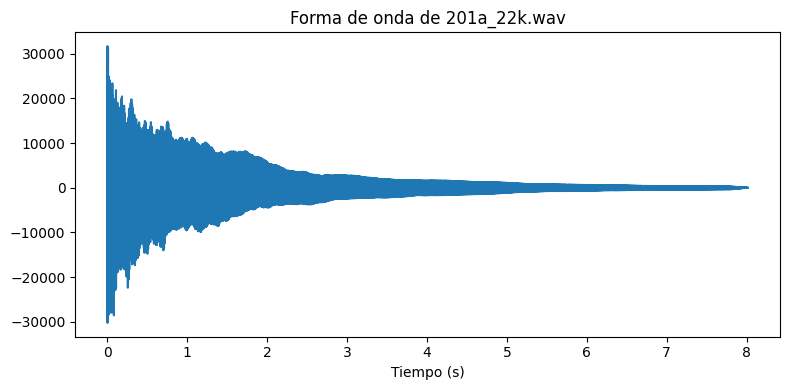

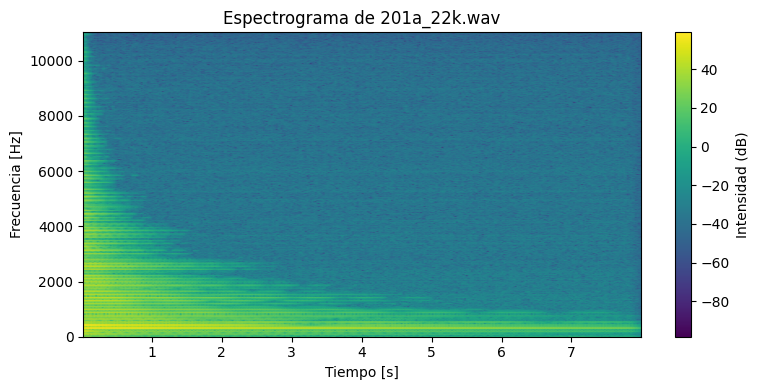

In [124]:
plt.figure(figsize=(8, 4))
plt.plot(np.linspace(0, len(guitar)/sr_guitar, len(guitar)), guitar)
plt.xlabel("Tiempo (s)")
plt.title("Forma de onda de 201a_22k.wav")
plt.tight_layout()
plt.show()

f, t, Sxx = signal.spectrogram(guitar, sr_guitar, nperseg=1024, noverlap=512)
plt.figure(figsize=(8, 4))
plt.pcolormesh(t, f, 10 * np.log10(Sxx), shading='gouraud')
plt.ylabel('Frecuencia [Hz]')
plt.xlabel('Tiempo [s]')
plt.title(f'Espectrograma de 201a_22k.wav')
plt.colorbar(label='Intensidad (dB)')
plt.tight_layout()
plt.show()

In [125]:
fs = 22050
R = 0.99999
f0 = 110
duration_s = 6 

L = int(round((fs / fn)) - (1/2))

# Señal de entrada
x = delta(int(fs*duration_s))

# Filtro peine
note_A2 = filtro_peine_con_pasabajos(x, L, R)

Audio(note_A2, rate=fs)

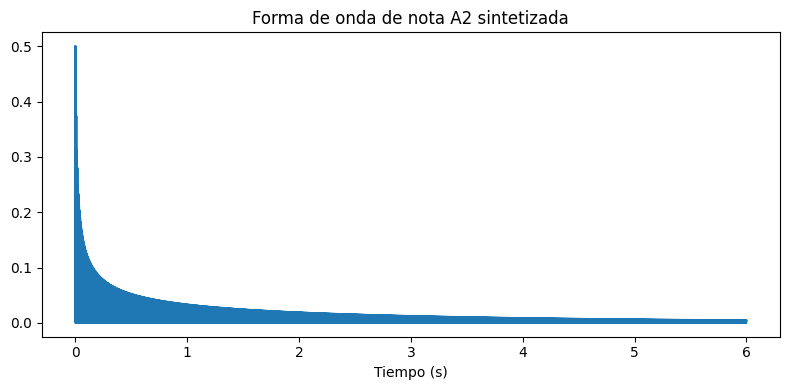

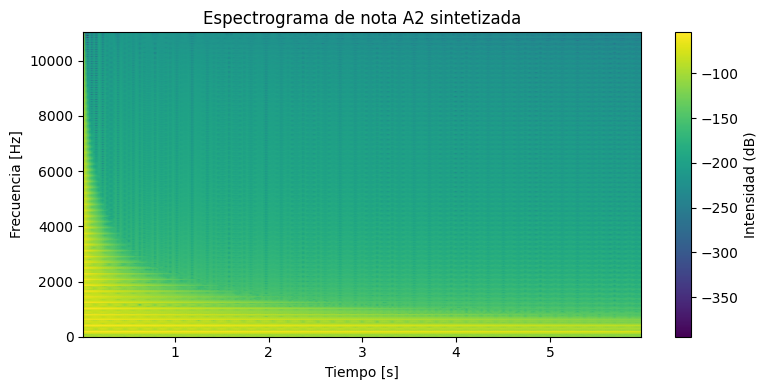

In [126]:
plt.figure(figsize=(8, 4))
plt.plot(np.linspace(0, len(note_A2)/fs, len(note_A2)), note_A2)
plt.xlabel("Tiempo (s)")
plt.title("Forma de onda de nota A2 sintetizada")
plt.tight_layout()
plt.show()

f, t, Sxx = signal.spectrogram(note_A2, fs, nperseg=1024, noverlap=512)
plt.figure(figsize=(8, 4))
plt.pcolormesh(t, f, 10 * np.log10(Sxx), shading='gouraud')
plt.ylabel('Frecuencia [Hz]')
plt.xlabel('Tiempo [s]')
plt.title(f'Espectrograma de nota A2 sintetizada')
plt.colorbar(label='Intensidad (dB)')
plt.tight_layout()
plt.show()

**_Respuesta:_**

## Parte 4

Como segunda etapa de refinamiento del modelo se incluye un filtro pasatodos (con un polo en \(a\) y un cero en \(1/a\)) en serie con el filtro pasabajos.

Su objetivo es crear retardos fraccionarios para producir frecuencias fundamentales arbitrarias.


1. Calcular la ecuación en recurrencia del filtro peine incluyendo el pasabajos y el pasatodos en el lazo de realimentación.
1. Indicar la frecuencia fundamental de la respuesta al impulso en función de los parámetros de los filtros peine y pasatodos, y la frecuencia de muestreo.
1. Repetir el punto 2 de la parte 1 afinando el sistema en la frecuencia exacta de las notas de la escala. En el primer paso además de calcular el parámetro \(L\) del filtro peine hay que calcular el parámetro \(a\) del filtro pasatodos.
1. Calcular experimentalmente el error (en Hz) entre la frecuencia fundamental de cada nota sintetizada y su correspondiente en la escala temperada, con y sin el uso del filtro pasatodos. ¿A qué se debe dicho error?

**Observación:** como la frecuencia fundamental de una nota no varía en el tiempo, es posible obtener una estimación bastante precisa mediante la detección del primer pico de la DFT de la señal completa de la nota.

1.

Pasa-bajos: $L(z)=\frac{1}{2}(1+z^{-1})$

Pasa-todos:  $A(z)=\frac{1-az}{z-a}$

Planteando $\frac{Y(z)}{X(z)} = \frac{L(z) A(z)}{1 - L(z) A(z) R^{L}z^{-L}}$ se obtiene la siguiente ecuación en recurrencia:

$y[n] = \frac{1}{2} \left[-a x[n]+(1-a)x[n-1]+x[n-2] +R^L \left( -a y[n-L] +(1-a) y[n-L-1] + y[n-L-2] \right) \right] +ay[n-1]$



2.

El filtro pasa-todos tiene una respuesta de fase $\arg (A(e^{j \theta })) = - \delta \theta$, con $\delta = \frac{1-a}{1+a}$. Como es de fase lineal este filtro agrega un retardo de $\delta$ muestras para todas las frecuencias. Cuando se combina este retardo adicional con el ya existente retardo de media muestra del filtro pasa-bajos y el retardo L del bucle de realimentación, el resultado es un aumento en la longitud total del bucle. Consecuentemente, la frecuencia fundamental del sistema se ajusta para reflejar este nuevo retardo total: $f_0=\frac{f_s}{L+\frac{1}{2}+\delta}$. 

Notar que el propósito de este filtro-pasatodos es justamente poder conseguir una frecuencia fundamental arbitratria, ya que L es entero pero ahora $\delta$ es una parte fraccionaria a elección, y en términos de ganancia este filtro no tiene ningún efecto.

3.

In [127]:
def filtro_peine_con_pasabajos_pasatodos(x, L, R, a):
    """
    Filtro peine con filtro pasa-bajos y pasa-todos

    y[n] = (1/2) [-a*x[n] + (1-a)*x[n-1] + x[n-2] + R^L*(-a*y[n-L] + (1-a)*y[n-L-1] + y[n-L-2])] + a*y[n-1]
   
    Args:
        x (np.array): señal de entrada
        L (int): parámetro L del filtro peine
        R (float): parámetro R del filtro peine
        a (float): parámetro a del filtro
    Returns:
        np.array: señal de salida
    """

    y = np.zeros(len(x))
    
    # Inicializar los primeros valores de y
    y[0] = - 0.5 * a * x[0]
    y[1] = 0.5 * (-a*x[1] + (1-a)*x[0]) + a*y[0]
    
    # Aplicar el filtro
    for n in range(2, y.shape[0]):
        if n < L:
            y[n] = 0.5 * (-a*x[n] + (1-a)*x[n-1] + x[n-2]) + a*y[n-1]
        elif n == L:
            y[n] = 0.5 * (-a*x[n] + (1-a)*x[n-1] + x[n-2] + R**L * (-a)*y[n-L]) + a*y[n-1]
        elif n == L+1:
            y[n] = 0.5 * (-a*x[n] + (1-a)*x[n-1] + x[n-2] + R**L * ((-a)*y[n-L] + (1-a)*y[n-L-1])) + a*y[n-1]
        else: # n > L+1
            y[n] = 0.5 * (-a*x[n] + (1-a)*x[n-1] + x[n-2] + R**L * ((-a)*y[n-L] + (1-a)*y[n-L-1] + y[n-L-2])) + a*y[n-1]
    
    return y


In [128]:
fs = 22050
R = 0.999
f0 = 110
duration_s = 0.5 # duracion de cada nota

# generar las 12 notas
notes_pasabajos_pasatodos = []
for i in range(12):
    fn = f0 * 2**(i / 12)

    L = int(np.floor(fs/fn - 1/2))

    # f0 = fs/(L + 1/2 + delta) --> delta = fs/f0 - 1/2 - L
    delta_tune = (fs/fn) - 1/2 - L  
    
    a = (delta_tune - 1) / (delta_tune + 1)

    # Señal de entrada
    x = delta(int(fs*duration_s))

    # Filtro peine
    note = filtro_peine_con_pasabajos_pasatodos(x, L, R, a)

    notes_pasabajos_pasatodos.append(note)

# concatenar todas las notas
y = np.concatenate(notes_pasabajos_pasatodos)

Audio(y, rate=fs)

4.

In [129]:
def frecuencia_fundamental(data, sr, debug=False):
    fft_ = fft(data, n=int(sr/0.001))
    n = len(fft_)
    fft_mag = np.abs(fft_[:n//2]) 
    freqs = fftfreq(n, 1/sr)[:n//2]
    
    if debug:
        plt.figure()
        plt.plot(freqs, fft_mag)
        plt.xlabel("Frecuencia (Hz)")
        plt.grid()

    peaks, _ = find_peaks(fft_mag) 
    
    if len(peaks) == 0:
        return None 
    
    fundamental_idx = peaks[0]
    fundamental_freq = freqs[fundamental_idx]
    
    return fundamental_freq

np.float64(116.541)

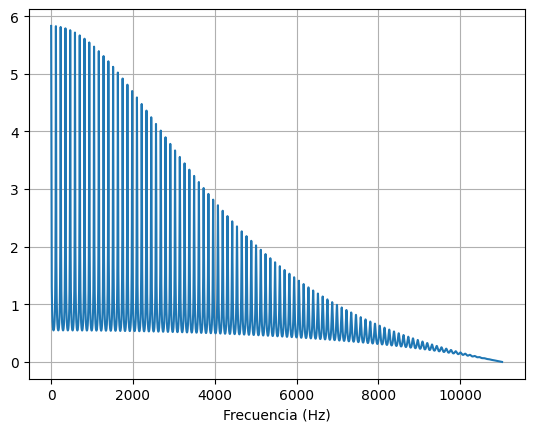

In [130]:
frecuencia_fundamental(data=notes_pasabajos_pasatodos[1], sr=fs, debug=True)

In [131]:
resultados = []
for i in range(12):
    nota = 110 * 2**(i/12)
    error_pasabajos = frecuencia_fundamental(data=notes_pasabajos[i], sr=fs) - nota
    error_pasatodos = frecuencia_fundamental(data=notes_pasabajos_pasatodos[i], sr=fs) - nota
    
    resultados.append([nota, error_pasabajos, error_pasatodos])

headers = ["Nota escala temperada (Hz)", "Error sistema pasabajos (Hz)", "Error sistema pasatodos (Hz)"]
print(tabulate(resultados, headers=headers, tablefmt="fancy_grid"))

╒══════════════════════════════╤════════════════════════════════╤════════════════════════════════╕
│   Nota escala temperada (Hz) │   Error sistema pasabajos (Hz) │   Error sistema pasatodos (Hz) │
╞══════════════════════════════╪════════════════════════════════╪════════════════════════════════╡
│                      110     │                     0.519      │                    0           │
├──────────────────────────────┼────────────────────────────────┼────────────────────────────────┤
│                      116.541 │                     0.42806    │                    5.96205e-05 │
├──────────────────────────────┼────────────────────────────────┼────────────────────────────────┤
│                      123.471 │                     0.0511747  │                    0.000174686 │
├──────────────────────────────┼────────────────────────────────┼────────────────────────────────┤
│                      130.813 │                     0.0402173  │                    0.00021735  │
├─────────

# Referencias

[1] Scheirer, Eric D, "Tempo and beat analysis of acoustic musical signals", *The Journal of the Acoustical Society of America,* vol. 103, no.1, pp.588 601, 1998.

[2] ethno beat.wav by zagi2 -- https://freesound.org/s/353234/ -- License: Attribution NonCommercial 4.0

[3] Kevin Karplus and Alex Strong, "Digital Synthesis of Plucked String and Drum Timbres", *Computer Music Journal,* vol.7, no.2, pp. 43-55, 1983.

[4] Ken Steiglitz, *Digital Signal Processing Primer: With Applications to Digital Audio and Computer Music,* ch. Comb and String Filters. Prentice Hall, 1996.

[5] 201A.wav by casualdave -- https://freesound.org/s/44729/ -- License: Sampling+
